Q1. Prepare Documents

In [1]:
import json

with open('documents.json', 'rt') as f_in:
    docs_raw = json.load(f_in)

documents = []

for course_dict in docs_raw:
    for doc in course_dict['documents']:
        doc['course'] = course_dict['course']
        documents.append(doc)

len(documents)


948

Q2. Create Embeddings using Pretrained Models

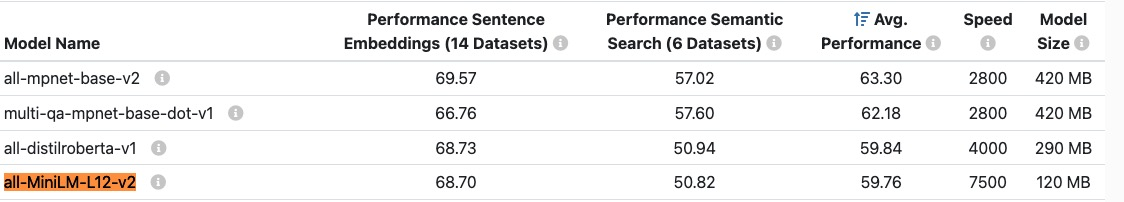

120MB, 59.76

Q3. Get the dimension for model embedding

In [2]:
# This is a new library compared to the previous modules. 
# Please perform "pip install sentence_transformers==2.7.0"

from sentence_transformers import SentenceTransformer

# if you get an error do the following:
# 1. Uninstall numpy 
# 2. Uninstall torch
# 3. pip install numpy==1.26.4
# 4. pip install torch
# run the above cell, it should work
model = SentenceTransformer("all-MiniLM-L12-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [3]:
len(model.encode("This is a simple sentence"))

384

In [4]:
#created the dense vector using the pre-trained model
operations = []
for doc in documents:
    # Transforming the title into an embedding using the model
    doc["question_vector"] = model.encode(doc["question"]).tolist()
    operations.append(doc)

In [5]:
from elasticsearch import Elasticsearch
es_client = Elasticsearch('http://localhost:9200') 

es_client.info()

ObjectApiResponse({'name': '80b1c5f7f274', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'eP-PVSDMRW6QweVQoR6OAg', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

Q4: Create Mappings and Index

In [6]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "keyword"},
            "question": {"type": "text"},
            "course": {"type": "keyword"} ,
            "question_vector":{"type":"dense_vector","dims": 384,"index":True,"similarity": "cosine"
        },
        }
    }
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [7]:
for doc in operations:
    try:
        es_client.index(index=index_name, document=doc)
    except Exception as e:
        print(e)

If the index is unavailable, skip this statement
ignore_unavailable (bool | None) – If false, the request returns an error if it targets a missing or closed index.

Q5: Create end user query and perform semantic search

In [11]:
search_term = "how to enrol to course?"
vector_search_term = model.encode(search_term)

query = {
    "field" : "question_vector",
    "query_vector" :  vector_search_term,
    "k" : 5,
    "num_candidates" : 10000, 
}

res = es_client.search(index=index_name, knn=query,source=["text","section","question","course"])
res["hits"]["hits"][0]

{'_index': 'course-questions',
 '_id': 'vV2YjpABJzzgAMTb4p9G',
 '_score': 0.852048,
 '_source': {'question': 'Course - What are the prerequisites for this course?',
  'course': 'data-engineering-zoomcamp',
  'section': 'General course-related questions',
  'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites'}}

[0.74, 'General course-related questions', 'data-engineering-zoomcamp']

Q6: Perform Semantic Search & Filtering

In [15]:
knn_query = {
    "field" : "question_vector",
    "query_vector" :  vector_search_term,
    "k" : 5,
    "num_candidates" : 10000
}

response = es_client.search(
    index=index_name,
    query={
        "match": {
                "section": "General course-related questions"
            },
        },
        
    knn=knn_query,
    size=5
)



In [20]:
result = response["hits"]["hits"]
result

[{'_index': 'course-questions',
  '_id': 'vV2YjpABJzzgAMTb4p9G',
  '_score': 3.4953291,
  '_source': {'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
   'section': 'General course-related questions',
   'question': 'Course - What are the prerequisites for this course?',
   'course': 'data-engineering-zoomcamp',
   'question_vector': [0.0431210994720459,
    0.05837034061551094,
    0.0050229644402861595,
    0.028570566326379776,
    -0.022065475583076477,
    0.0047318837605416775,
    -0.02545987069606781,
    -0.0008887423318810761,
    -0.16603538393974304,
    -0.004694742150604725,
    -0.05639377236366272,
    -0.10678314417600632,
    -0.060213178396224976,
    0.039712484925985336,
    -0.06361552327871323,
    0.03923671692609787,
    -0.0044054496102035046,
    -0.008392630144953728,
    0.14483696222305298,
    -0.07729388028383255,
    0.015076647512614727,
    0.020861973986029625,
    0.019407782703638077,
    -0.031069470569491386,
    0.007932

In [22]:
list1 = list(filter(lambda x: x["_source"]["section"] ==  "General course-related questions", result))
len(list1)

5

YES